# 数据增强：数据加载器

In [1]:
import time
import os
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from torchvision import transforms
from torchvision.transforms import v2
from torchvision import datasets

from torch.utils.data import DataLoader

from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 忽略烦人的红色提示
warnings.filterwarnings("ignore")
    
import wandb

from glob import glob

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device',device)

device cuda:0


In [3]:
train_transform = v2.Compose([
#     将输入图像调整为256x256像素大小，这有助于保持输入图像的一致性大小
    v2.Resize(256),
#     随机裁剪图像以大小244x244像素，这种随机裁剪有助于模型学习到不同部分的特征，antialias=True可使图像更加平滑
    v2.RandomResizedCrop(size=(244,244),antialias=True),
#     以50%的概率对图像进行水平翻转，增加训练数据的多样性，模型可以学习到不同方向的特征。
    v2.RandomHorizontalFlip(p=0.5),
    #垂直翻转
    v2.RandomVerticalFlip(p=0.5),
#   随机仿射变换，包括旋转(-10到10度)、平移(最大移动图像宽高的10%)
#   和缩放(0.9到1.1倍)，增加图像的变化，帮助模型更好地适应不同角度、大小和位置的物体。
    v2.RandomAffine(degrees=(-10,10),translate=(0.1,0.1),scale=(0.9,1.1)),
    #以50%的概率对图像进行随机擦除，这有助于模型学习对局部遮挡的鲁棒性。
    v2.RandomErasing(p=0.5,scale=(0.1,0.15)),
    #将图像转换为PyTorch张量，适配PyTorch模型的输入要求。
    v2.ToTensor(),
    #将张量数据类型转换为float32，确保与模型的输入类型匹配。
    v2.ToDtype(torch.float32),
#   对图像进行标准化，减去均值并除以标准差，这有助于模型更快地收敛，并使输入数据分布更符合模型预期。
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
test_transform = v2.Compose([
    v2.Resize((244,244)),
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,dataframe,transforms_):
# 存储了传入的 DataFrame，这里假设 DataFrame 中包含图像路径和对应的类别标签。
        self.df = dataframe
# 是用来进行数据增强和将 PIL 图像转换为 PyTorch 张量的转换函数。
        self.transforms_ = transforms_
        self.original = None
#返回数据集的长度，即 DataFrame 中的行数，代表数据集中样本的数量。
    def __len__(self):
        return len(self.df)
    #根据给定的索引 index 获取样本。
    def __getitem__(self,index):
#       从 DataFrame 中读取图像路径和类别标签
        image_path = self.df.iloc[index]['path']
#      将图像转换为 RGB 模式。
        img = Image.open(image_path).convert("RGB")
#      应用了预先定义的转换函数 self.transforms_ 对图像进行变换（数据增强、转换为张量等）
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        #原始图像
#      返回转换后的图像和对应的类别标签。
        return transformed_img,class_id

In [17]:
data_path = 'D:/DL/CV/用于混合菌种检测的注意力增强残差神经网络/dataset/'
#创建一个空的 DataFrame，包括三列：path 存储图像路径、label 存储图像类别的名称、class_id 存储对应的类别 ID
df = pd.DataFrame({"path":[],
                  "label":[],
                  "class_id":[]})
# 包含类别名称和对应的类别 ID。这个字典用于将类别名称映射到整ID。这个字典用于将类别名称映射到整数ID
label_dict = {
    "TSH":0,
    "BASH":1,
    "GMA":2,
    "SHC":3,
    "BBH":4
}

for key in label_dict:
#   对于每个类别，使用 os.path.join() 构建类别文件夹的路径
    img_path = os.path.join(data_path,key)
#   使用 glob.glob() 获取类别文件夹中所有 .jpg 图像的文件列表
    jpg_list = glob(img_path + '/*.jpg')
#     对于每个找到的图像，将图像路径、类别名称和对应的类别 ID 添加到新的 DataFrame 行中，然后将这行数据添加到整体的 DataFrame 中
    for jpg in jpg_list:
        new_data = pd.DataFrame({"path":jpg,
                                 "label":key,
                                 "class_id":label_dict[key]},
                                index=[1])
        df = pd.concat([df,new_data],ignore_index=True)
# 通过 astype() 方法将 path 和 label 列转换为字符串类型，class_id 列转换为整数类型。
df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)
df[["class_id"]] = df[["class_id"]].astype(int)

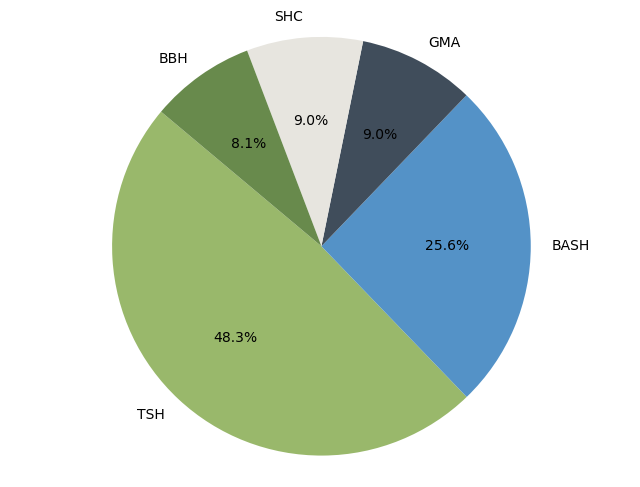

In [18]:
import matplotlib.pyplot as plt

# 计算不同标签的数量
label_counts = df['label'].value_counts()

# 获取标签和对应的计数
labels = label_counts.index
sizes = label_counts.values
color = [
     (153/255,184/255,107/255),
    (84/255,146/255,199/255),
    (64/255,77/255,91/255),
    (231/255,229/255,223/255),
    (104/255,138/255,76/255)
]
# 绘制饼图
plt.figure(figsize=(8, 6))  # 设置图形大小
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,colors=color)  # autopct 显示百分比，startangle 设置起始角度
plt.axis('equal')  # 使饼图比例相等，显示为圆形
plt.show()

In [7]:
df.head()

,path,label,class_id
0,D:/DL/CV/用于混合菌种检测的注意力增强残差神经网络/dataset/TSH\H1_1...,TSH,0
1,D:/DL/CV/用于混合菌种检测的注意力增强残差神经网络/dataset/TSH\H1_1...,TSH,0
2,D:/DL/CV/用于混合菌种检测的注意力增强残差神经网络/dataset/TSH\H1_1...,TSH,0
3,D:/DL/CV/用于混合菌种检测的注意力增强残差神经网络/dataset/TSH\H1_1...,TSH,0
4,D:/DL/CV/用于混合菌种检测的注意力增强残差神经网络/dataset/TSH\H1_1...,TSH,0


In [8]:
df.describe()

,class_id
count,9114.000000
mean,1.029405
std,1.288859
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,4.000000


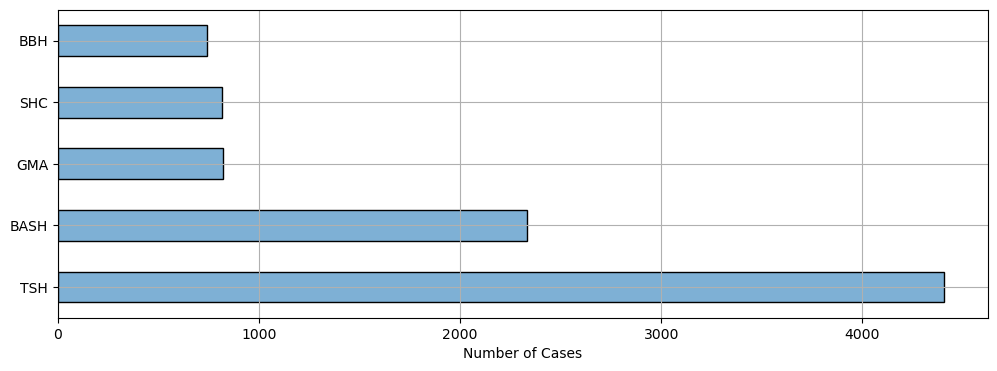

In [9]:
df['label'].value_counts().plot(
    kind = 'barh', figsize = (12,4), grid = True, color = "#7eb0d5", edgecolor = 'black')
plt.xlabel('Number of Cases')
plt.show()

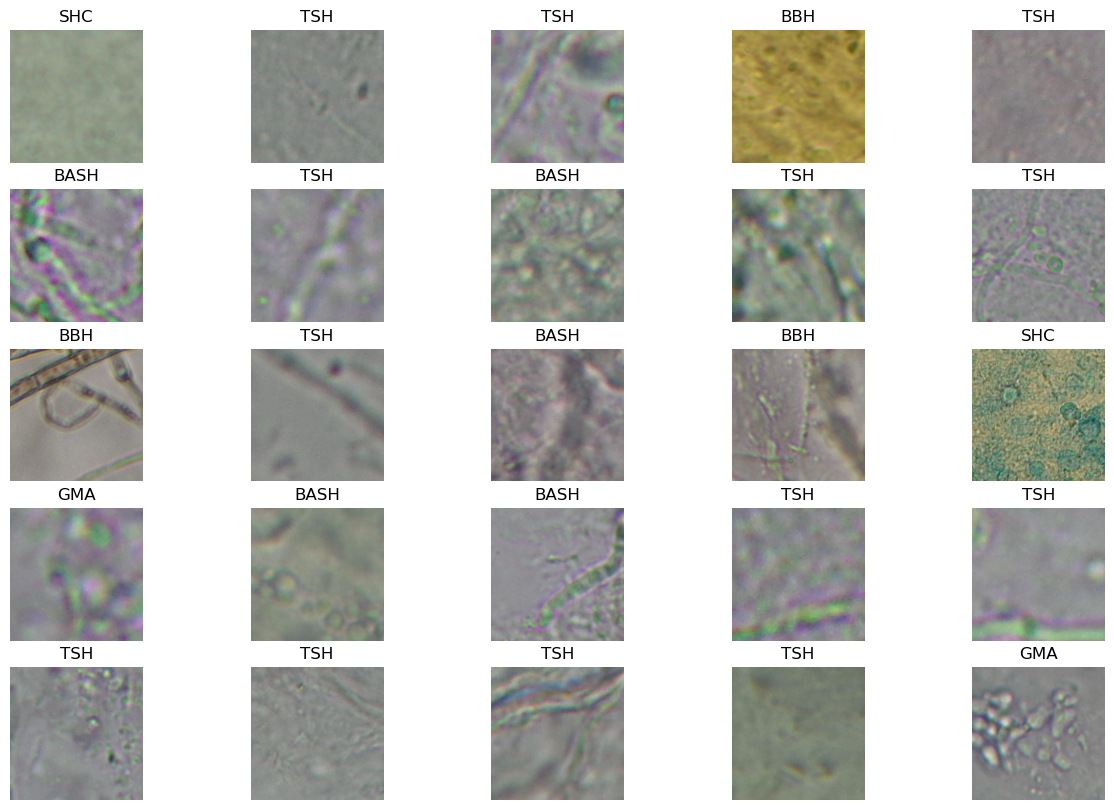

In [10]:
show_imgs = 25
# idx 是一个随机生成的整数数组，包含了从 0 到 DataFrame 长度之间的随机索引，用于随机选择图像样本
idx = np.random.randint(0,len(df),size=show_imgs)
#使用 plt.subplots() 创建一个图像网格，行数为 show_imgs//5（整除），列数为 5，总共展示 show_imgs 张图像
fig,axes = plt.subplots(show_imgs//5,5,figsize=(15,10))
# 展平成一维数组
axes = axes.flatten()
# enumerate 返回一个包含索引和对应元素的迭代器。
for i,ax in enumerate(axes):
    full_path = df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [11]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state=47)
train_dataset = MyDataset(train_df,train_transform)
test_dataset = MyDataset(val_df,test_transform)

#加载到torch上
BATCH_SIZE = 500  #降维可视化调大
# BATCH_SIZE = 32
# BATCH_SIZE = 24
# BATCH_SIZE = 6
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE)

print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:7291
val data:1823


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

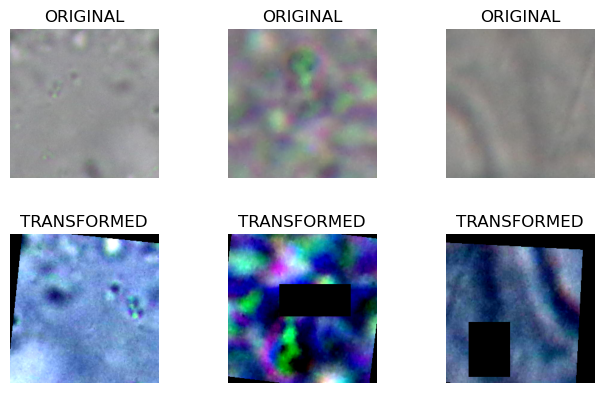

<Figure size 1200x1200 with 0 Axes>

In [12]:
for i in range(3):
    image_path = train_df.iloc[i]['path']
    #      将图像转换为 RGB 模式。
    img = Image.open(image_path).convert("RGB")
    #      应用了预先定义的转换函数 self.transforms_ 对图像进行变换（数据增强、转换为张量等）
#     transformed_img = trans(img)
#     transformed_img =test_transform(img)
    transformed_img = train_transform(img)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title('ORIGINAL')
    plt.axis(False)
    plt.tight_layout(w_pad=5, pad=2)

    plt.subplot(2,3,i+4)
    plt.imshow(torch.permute(transformed_img, (1,2,0)))
    plt.title('TRANSFORMED')
    plt.axis(False)
    plt.tight_layout(w_pad=5, pad=2)

plt.figure(figsize=(12, 12))
plt.show

# 模型选择

In [13]:
class_size = 5

## 迁移学习

### 预训练模型：ResNet18，只修改最后一层

In [14]:
model_resnet18 = models.resnet18(pretrained = True)
model_name_resnet18 = 'ResNet18_translearning'
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features,class_size)
model_resnet18(torch.randn(16,3,256,256)).shape

torch.Size([16, 5])

### 预训练模型ResNet50，只修改最后一层

In [15]:
model_resnet50 = models.resnet50(pretrained = True)
model_name_resnet50 = 'ResNet50_translearning'
model_resnet50.fc = nn.Linear(model_resnet50.fc.in_features,class_size)
model_resnet50(torch.randn(16,3,256,256)).shape

KeyboardInterrupt: 

### 预训练模型 MobileNet，只修改最后一层

In [ ]:
class CustomMobileNetV3(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomMobileNetV3, self).__init__()
        self.base_model = models.mobilenet_v3_small(pretrained=True)
        # 修改最后一层全连接层的输出节点数，以适应五分类任务
        in_features = self.base_model.classifier[-1].in_features
        self.base_model.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

model_MobileNet =  CustomMobileNetV3()
model_name_MobileNet = 'MobileNet_translearning'
model_MobileNet(torch.randn(16,3,256,256)).shape

### MicroNet Model

In [ ]:
# !pip install torchviz
from flatten_pvt_v2 import *

model_pretrained = models.resnet18(pretrained=True)
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features,class_size)

model_pretrained.load_state_dict(torch.load("0.8793best_ResNet18_translearning.pth"))

# 在每个残差块后添加自注意力模块
for name, module in model_pretrained.named_children():
#     if name == "layer1" or name == "layer2" or name == "layer3" or name == "layer4":
     if name == "layer1": 
        for block in module:
            # 添加自注意力模块
            setattr(block, 'attention',flatten_pvt_v2_b0(block.conv1.out_channels))
        
class CustomMicroscopyNet(nn.Module):
    def __init__(self):
        super(CustomMicroscopyNet, self).__init__()
        self.base_model = model_pretrained
        
    def forward(self, x):
        
        return self.base_model(x)

model_MicroscopyNet =  CustomMicroscopyNet()

model_name_MicroscopyNet = 'MicroscopyNet_translearning'
model_MicroscopyNet(torch.randn(16,3,256,256)).shape

In [ ]:
from torchsummary import summary
model_MicroscopyNet = model_MicroscopyNet.to(device)
# 假设你的模型名为 model_MicroscopyNet
# 你可以调用 summary 函数来打印模型结构
summary(model_MicroscopyNet, input_size=(3, 256, 256))  # 这里假设输入大小为 (3, 256, 256)


## 开始训练！！！

In [ ]:
def train(dataloader,model,loss_fn,optimizer,lr_scheduler):
    #数据集大小
    size = len(dataloader.dataset)
    #数据集批次数
    num_batches = len(dataloader)
    #训练模式
    model.train()
    #初始化每个epoch损失
    epoch_loss = 0.0
    #正确预测数量
    epoch_correct = 0
    for (data_,target_) in dataloader:
        #将标签转换为整型张量类型
        target_ = target_.type(torch.LongTensor)
        #加载到GPU
        data_,target_ = data_.to(device),target_.to(device)
        # 清零优化器的梯度
        optimizer.zero_grad()
        # 通过模型进行前向传播
        outputs = model(data_)
         # 计算损失
        loss = criterion(outputs,target_)
        # 反向传播损失
        loss.backward()
        # 更新模型参数
        optimizer.step()
        # 累积每个 epoch 的损失
        epoch_loss = epoch_loss + loss.item()
        # 获取预测结果中的最大值
        _,pred = torch.max(outputs,dim=1)
         # 累积每个 epoch 的正确预测数
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
        
     # 更新学习率
    lr_scheduler.step()
     # 返回每个 epoch 的准确率和平均损失
    return epoch_correct/size,epoch_loss/num_batches

def test(dataloader,model,loss_fn):
     # 获取数据集大小
    size = len(dataloader.dataset)
    # 获取数据集批次数
    num_batches = len(dataloader)
    # 初始化每个 epoch 的损失
    epoch_loss = 0.0
    # 初始化每个 epoch 的正确预测数
    epoch_correct = 0
    # 禁用梯度计算
    with torch.no_grad():
        # 设置模型为评估模式
        model.eval()
        # 遍历测试数据集批次
        for (data_,target_) in dataloader:
            # 将目标数据转换为长整型张量类型
            target_ = target_.type(torch.LongTensor)
             # 将数据和目标移到指定设备
            data_,target_ = data_.to(device),target_.to(device)
           # 通过模型进行前向传播获取预测结果
            outputs = model(data_)
            # 计算损失
            loss = criterion(outputs,target_)
            # 累积每个 epoch 的损失
            epoch_loss = epoch_loss + loss.item()
            # 获取预测结果中的最大值
            _,pred = torch.max(outputs,dim = 1)
            # 累积每个 epoch 的正确预测数
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    # 返回每个 epoch 的准确率和平均损失
    return epoch_correct/size,epoch_loss/num_batches

In [ ]:
!wandb login

In [ ]:
#命令行输入  wandb login 登录
######登录wandb可视化项目######
# model_name = model_name_MobileNet
# model_name = model_name_resnet50
model_name = model_name_MicroscopyNet
wandb.init(project=f'd efungi_{model_name}', name=time.strftime('%m%d%H%M%S'))
print("wandb初始化完成")

In [ ]:
#训练批次
EPOCHS = 50
#损失计算方式：
criterion  = nn.CrossEntropyLoss()
#超参数
learning_rate = 0.0001 #学习率
# learning_rate = 0.01
momentum = 0.9  #动量
weight_decay = 0.1 #权重衰弱率

In [ ]:
def run(model,model_name):
    #优化器选择
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=learning_rate,
    #AdamW优化器中的两个beta参数，分别用于计算梯度的一阶矩和二阶矩的指数衰减率。
                                  betas=(0.9,0.999), 
    #一个小的常数，用于增加数值稳定性，防止除以零的情况发生
                                 eps=1e-08,
    #L2正则化项的权重衰减参数，用于惩罚模型的复杂性，避免过拟合   
                                 weight_decay=weight_decay,
    #控制是否使用AMSGrad变种，该变种在Adam优化器中改变了参数的更新方式。                              
                                 amsgrad=False)
    #优化器2学习率里程碑
    optimizer = torch.optim.AdamW(model.parameters(),lr = learning_rate)
    # 即在训练的第7、14、21、28和35个epoch时，学习率将会被调整。
    lr_milestones = [7,14,21,28,35]
    # 初始化了一个多步学习率调度器（MultiStepLR）。
    # 它将在训练过程中根据给定的里程碑（milestones）来更新学习率。
    # 当训练到达这些特定的里程碑时，学习率会按照 gamma=0.1 给定的比例进行调整（将学习率乘以0.1）。
    multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=lr_milestones,
                                                      gamma=0.1)
    # Earlystopping 及时中断技术
    patience = 5
    counter = 0
    best_loss = np.inf
    #加载到GPU
    model.to(device)
    # 训练日志-训练集
    logs = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

    #遍历每一个epoch
    for epoch in tqdm(range(EPOCHS)):
        #训练
        train_acc,train_loss = train(train_loader,model,criterion,optimizer,multi_step_lr_scheduler)
        #验证
        val_acc,val_loss = test(val_loader,model,criterion)
        #打印结果
        print(f'EPOCH:{epoch} \
              train_loss:{train_loss:.4f},train_acc:{train_acc:.3f}\
              val_loss:{val_loss:.4f},val_acc:{val_acc:.3f}\
              Learning Rate:{optimizer.param_groups[0]["lr"]}')
        #写入日志
        log = {
        'epoch': epoch,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }
        logs = logs.append(log, ignore_index=True)
        wandb.log(log)
        #保存模型:直接覆盖避免占内存
        torch.save(model.state_dict(),"last.pth")
        #择优:选择验证集上累积损失最小的模型参数
        if val_loss < best_loss:
            counter = 0
            best_loss = val_loss
            torch.save(model.state_dict(),f"best_{model_name}.pth")
        else:
            counter += 1
        #查看是否满足提前终止条件
        if counter >= patience :
            print("Earlystop!")
            break
    return logs
# logs_resnet18 = run(model_resnet18,model_name_resnet18)
# logs_mobilenetv3 = run(model_MobileNet,model_name_MobileNet)
# logs_resnet50 = run(model_resnet50,model_name_resnet50)
logs_MicroscopyNet = run(model_MicroscopyNet,model_name_MicroscopyNet)

In [ ]:
def plt_logs(logs,model_name):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(logs['train_loss'],label='Train_Loss')
    plt.plot(logs['val_loss'],label='Validation_Loss')
    plt.title('Train_Loss & Validation_Loss',fontsize=20)
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(logs['train_acc'],label='Train_Accuracy')
    plt.plot(logs['val_acc'],label='Validation_Accuracy')
    plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
    plt.legend()
    print("模型精度：",np.max(logs['val_acc']))
    plt.savefig(f'log_{model_name}.jpg',dpi = 500)
    plt.show()
# plt_logs(logs_resnet18,model_name_resnet18)
# plt_logs(logs_mobilenetv3,model_name_MobileNet)
# plt_logs(logs_resnet50,model_name_resnet50)
plt_logs(logs_MicroscopyNet,model_name_MicroscopyNet)

# tsne模型卷积层可视化

In [ ]:
#BATCH_SIZE 改到500
def save_last_conv_output(dataloader, model, model_name,loss_fn):
    model = model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss = 0.0
    epoch_correct = 0
    last_conv_output = []  # 用于存储最后一个卷积层的输出
    labels = []  # 存储标签

    with torch.no_grad():
        model.eval()
        for (data_, target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # 逐层传递数据并记录中间层的输出
            output = data_
            
            if model_name == "ResNet18_translearning" or model_name == "ResNet50_translearning":
                for name, layer in model.named_children():
                    output = layer(output)
                    if name == 'layer4':
                        intermediate_output = output  # 记录最后一个卷积层的输出
                        break
                # 存储最后一个卷积层的输出结果和标签信息
                last_conv_output.append(intermediate_output.cpu().numpy())
                labels.append(target_.cpu().numpy())
                
            if model_name == "MobileNet_translearning":
                for name, layer in model.base_model.named_children():
                    if name == 'features':
                        intermediate_output = layer(output)
                        break
                    output = layer(output)
#                 # 存储最后一个卷积层的输出结果和标签信息
                last_conv_output.append(intermediate_output.cpu().numpy())
                labels.append(target_.cpu().numpy())
                
            if model_name == "MicroscopyNet_translearning":
                for name, layer in model.base_model.named_children():
                    output = layer(output)
                    if name == 'layer4':
                        intermediate_output = output  # 记录最后一个卷积层的输出
                        break
                # 存储最后一个卷积层的输出结果和标签信息
                last_conv_output.append(intermediate_output.cpu().numpy())
                labels.append(target_.cpu().numpy())
    
    # 将最后一个卷积层的输出和对应的标签保存为 .npy 文件
    last_conv_output_npy = np.concatenate(last_conv_output)
    labels_npy = np.concatenate(labels)
    np.save(f'last_conv_output_{model_name}.npy', last_conv_output_npy)
    np.save(f'labels_{model_name}.npy', labels_npy)

    return last_conv_output, labels

# # 加载参数文件中的状态字典
# state_dict = torch.load("best_ResNet50_translearning.pth")
state_dict = torch.load("best_MicroscopyNet_translearning.pth")
# # 将参数加载到模型中
# model_resnet50.load_state_dict(state_dict)
model_MicroscopyNet.load_state_dict(state_dict)

output_MicroscopyNet, labels_MicroscopyNet = save_last_conv_output(val_loader, model_MicroscopyNet,model_name_MicroscopyNet, criterion)
# output_resnet18, labels = save_last_conv_output(val_loader, model, criterion)
# output_resnet50, labels_resnet50 = save_last_conv_output(val_loader, model_resnet50,model_name_resnet50, criterion)
# output_mobilenetv3, labels_mobilev3 = save_last_conv_output(val_loader, model_MobileNet,model_name_MobileNet, criterion)

In [ ]:
def get_output_reshape(output,labels):
    print(output[0].shape)
    output = output[0]
    print(output.shape)
    output_reshape = output.reshape(output.shape[0],-1)
    print(output_reshape.shape)
    print(labels[0].shape)
    label = labels[0]
    print(label.shape)
    
    x_min, x_max = np.min(output_reshape, 0), np.max(output_reshape, 0)
    data_reshape =output_reshape / (x_max - x_min)
    return data_reshape,label
# data_reshape_resnet18 ,labels= get_output_reshape(output_resnet18)

# data_reshape_mobilenetv3 ,labels_mobilev3= get_output_reshape(output_mobilenetv3,labels_mobilev3)
# data_reshape_resnet50 ,labels_resnet50= get_output_reshape(output_resnet50,labels_resnet50)
data_reshape_MicroscopyNet ,labels_MicroscopyNet= get_output_reshape(output_MicroscopyNet,labels_MicroscopyNet)

In [ ]:
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
# !pip install imblearn
from imblearn.over_sampling import SMOTE

color1 = (30/255, 60/255, 46/255)
color2 = (52/255,105/255,57/255)
color3 = (160/255,193/255,85/255)
color4 = (247/255,229/255,153/255)
color5 = (91/255,151/255,68/255)

def plt_tsne_2D(x_train, y_train, model_name):
    x_train = np.nan_to_num(x_train)  # 将 NaN 和无穷大替换为 0 或者其他数值
    x_train = np.clip(x_train, a_min=-1e9, a_max=1e9)  # 将超出范围的值裁剪到指定范围内
    #SMOTE将为少数类生成额外的样本，直到其数量达到多数类大小的x%为止
    smote = SMOTE(sampling_strategy='all',random_state=42)
    x_train, y_train = smote.fit_resample(x_train, y_train)
    x_train = TSNE(n_components=2,
                   perplexity=50 ,
                   init='pca',
                   learning_rate=100,
                   random_state=42).fit_transform(x_train)
    plt.figure(figsize=(6, 6))
    r = 2  # Point size
    area = np.pi * r ** 2  # Point area
    
    H1 = x_train[y_train == 0]
#     print(len(H1))
    H2 = x_train[y_train == 1]
#     print(len(H2))
    H3 = x_train[y_train == 2]
#     print(len(H3))
    H5 = x_train[y_train == 3]
#     print(len(H5))
    H6 = x_train[y_train == 4]
#     print(len(H6))
    
    plt.scatter(H1[:, 0], H1[:, 1], s=area, c=color1, label='H1')
    plt.scatter(H2[:, 0], H2[:, 1], s=area, c=color2, label='H2')
    plt.scatter(H3[:, 0], H3[:, 1], s=area, c=color3, label='H3')
    plt.scatter(H5[:, 0], H5[:, 1], s=area, c=color4, label='H5')
    plt.scatter(H6[:, 0], H6[:, 1], s=area, c=color5, label='H6')
    plt.axis("off")
    plt.legend(loc='upper right')
    plt.xticks([])
    plt.yticks([])    
    plt.title('')
    plt.savefig(model_name, dpi=300)
    plt.show()
    return plt

# model_name = model_name_resnet50
model_name = model_name_MicroscopyNet
title = f't-SNE Visualization of {model_name}.jpg'

# plt_tsne_2D(data_reshape_resnet18, label, title)
# plt_tsne_2D(data_reshape_mobilenetv3, labels_mobilev3, title)
# plt_tsne_2D(data_reshape_resnet50, labels_resnet50, title)
plt_tsne_2D(data_reshape_MicroscopyNet, labels_MicroscopyNet, title)

# 消融对比

In [ ]:
df = pd.read_csv('ResNet18/train_acc.csv')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.ticker as ticker

colors = [(30/255, 60/255, 46/255),
          (247/255, 229/255, 153/255),
          (52/255, 105/255, 57/255), 
          (160/255, 193/255, 85/255), 
          ]  # 定义RGB颜色元组
marker = ['o','*','^','s']
# 文件夹路径
folders = ['ResNet50', 'ResNet18', 'MobileNet', 'MicroscopyNet']

# 读取并绘制 train_acc
plt.figure(figsize=(10, 6))
for i, folder in enumerate(folders):
    file_path = os.path.join(folder, 'train_acc.csv')
    data = pd.read_csv(file_path)
    linestyle = '--' if i % 2 == 0 else '-'  # 设置虚线和实线交替
    plt.plot(data['Step'], data['train_acc'] * 100,label=folder,linestyle=linestyle ,color=colors[i], marker=marker[i])  # 使用RGB颜色元组设置颜色和点的形状

plt.xlabel('Step', fontsize=12, fontweight='bold')  # 设置x轴标签的字号和粗细
plt.ylabel('Train Accuracy(%)', fontsize=12, fontweight='bold')  # 设置y轴标签的字号和粗细


# 移动图例到右下角，去掉边框
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), frameon=False,prop={'size': 24})

plt.title('')
plt.grid(False)
plt.savefig('Training Accuracy Comparison.jpg', dpi=500)
plt.show()

# 读取并绘制 val_acc
plt.figure(figsize=(10, 6))
for i, folder in enumerate(folders):
    file_path = os.path.join(folder, 'val_acc.csv')
    data = pd.read_csv(file_path)
    linestyle = '--' if i % 2 == 0 else '-'  # 设置虚线和实线交替
    plt.plot(data["Step"], data['val_acc']*100,label=folder,linestyle=linestyle ,color=colors[i],marker=marker[i])

plt.xlabel('Step', fontsize=12, fontweight='bold')  # 设置x轴标签的字号和粗细
plt.ylabel('Validation Accuracy(%)', fontsize=12, fontweight='bold')  # 设置y轴标签的字号和粗细

# 移动图例到右下角，去掉边框
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), frameon=False,prop={'size': 24})

plt.grid(False)
plt.savefig('Validation Accuracy Comparison.jpg',dpi = 500)
plt.show()

# 读取并绘制 train_loss 和 val_loss
# plt.figure(figsize=(10, 6))
# for i, folder in enumerate(folders):
#     file_path_train = os.path.join(folder, 'train_loss.csv')
#     file_path_val = os.path.join(folder, 'val_loss.csv')

#     data_train = pd.read_csv(file_path_train)
#     data_val = pd.read_csv(file_path_val)

#     plt.plot(data_train['Step'], data_train['train_loss'], label=f'{folder}_train_loss',color=colors[i])
    
#     plt.plot(data_val['Step'], data_val['val_loss'], label=f'{folder}_val_loss',color=colors[i])

# plt.xlabel('Step')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('')
# plt.grid(False)
# plt.savefig('Training and Validation Loss Comparison.jpg',dpi = 500)
# plt.show()


In [ ]:
from sklearn.metrics import classification_report

#文件地址
model_resnet18_filepath = './ResNet18结果/0.8793best_ResNet18_translearning.pth'
model_resnet50_filepath = './ResNet50结果/0.8963best_ResNet50_translearning.pth'
model_MobileNet_filepath = './MobileNetV3结果/0.8163_best_MobileNet_translearning.pth'
model_MicroscopyNet_filepath = './MicroscopyNet结果/0.9210best_MicroscopyNet_translearning.pth'

# 加载预训练权重
model_resnet18.load_state_dict(torch.load(model_resnet18_filepath))
model_resnet50.load_state_dict(torch.load(model_resnet50_filepath))
model_MobileNet.load_state_dict(torch.load(model_MobileNet_filepath))
model_MicroscopyNet.load_state_dict(torch.load(model_MicroscopyNet_filepath))

# 设置为评估模式
model_resnet18.eval()
model_resnet50.eval()
model_MobileNet.eval()
model_MicroscopyNet.eval()

# 创建模型列表
Mymodels = [model_resnet18, model_resnet50, model_MobileNet, model_MicroscopyNet]

def evaluate_model(model, test_loader):
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())  # 将真实标签添加到列表中
            y_pred.extend(predicted.cpu().numpy())  # 将预测标签添加到列表中
            
    return classification_report(y_true, y_pred)  # 返回模型的分类报告

for model in Mymodels:
    report = evaluate_model(model, val_loader)
    print(report)